## Imports

In [8]:
import os
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sc
import scipy.constants as c
phc = c.physical_constants
import sys

from scipy.interpolate import interp1d

DEG_TO_RAD = np.pi / 180
RAD_TO_DEG = 180 / np.pi

plot_color = 'grey'
mpl.rc('axes', edgecolor=plot_color, labelcolor=plot_color, grid=True, labelsize=25)
mpl.rc('xtick', color=plot_color, labelsize=16)
mpl.rc('ytick', color=plot_color, labelsize=16)
mpl.rc('figure', figsize=[13, 9])

sys.path.append('/home/excalibur/pCloudDrive/Informatik/Python/')
from self_written_functions import eprint

sys.path.append('/home/excalibur/Dropbox/Bachelor')
from main_class import *

## Importing Data

In [2]:
os.chdir("/home/excalibur/Dropbox/Bachelor")

In [3]:
runXX = EngAndDemData('87')
runXX.synchronizing_time()
runXX.get_final_data()

Synchronized time with a time-difference of 2.0275891996898174.


In [4]:
current_data = np.array([runXX.eng_means[0], runXX.dem_means[0]]).T
current_data_sym = np.array([runXX.eng_means[0] - 0.5, runXX.dem_means[0]]).T

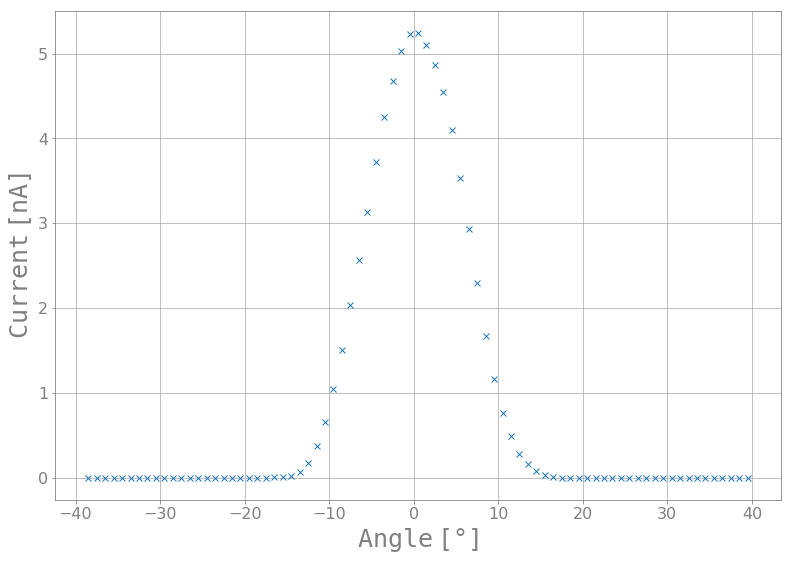

In [9]:
fig = plt.figure()
plt.plot(current_data_sym.T[0], current_data_sym.T[1], 'x') 
plt.xlabel(r"$\mathtt{Angle\/\/[°]}$")
plt.ylabel(r"$\mathtt{Current\/\/[nA]}$");

In [10]:
current_inter = interp1d(current_data_sym.T[0], current_data_sym.T[1], kind='cubic')

In [11]:
borders = (0, 35 * DEG_TO_RAD)

## Integrating Current

In [12]:
detector_distance = 7.5  # distance to detector [cm]
detector_window = 0.3  # diameter of detector window [cm]
detector_radius = detector_window / 2

In [13]:
detector_solid_angle = np.pi * detector_radius**2 / detector_distance**2

In [14]:
def integrand(theta):
    """
        theta [rad]
        returns: I_d_omega [nA / sr]
    """
    return current_inter(theta * RAD_TO_DEG) / detector_solid_angle * np.sin(theta) 

In [15]:
I_total = sc.integrate.quad(integrand, borders[0], borders[1])[0] * 2 * np.pi  # nA
I_total

241.89022780255894

## Current to n_photons

In [16]:
# response function at 365nm
R = 0.15 * 10**9  # nA / W

In [17]:
E_gamma = phc['Planck constant'][0] * phc['speed of light in vacuum'][0] / (365 * 10**-9)  # J

In [18]:
R_in = I_total / (E_gamma * R)  # n_photons / s
eprint(R_in)

2.963079e+12
